In [1]:
import numpy as np
# from YoungTree3 import yroot
# from YoungTree3 import yleaf
from YoungTree3.ytool import *
# from ytool import *
from numpy.lib.recfunctions import append_fields
from tqdm import tqdm
import matplotlib.pyplot as plt
from rur import uri, uhmi

In [2]:
params = importlib.import_module("params")
#########################################################
#   From params.py, record to dictionary
#########################################################
p = {}
for key in params.__dict__.keys():
    if not "_" in key:
        p[key] = params.__dict__[key]
    p["flush_GB"] = params.flush_GB
p = DotDict(p)

In [3]:
mode = 'y07206'
repo, rurmode, dp = mode2repo(mode)
# For message printing
galstr = "Halo"
galstrs = "Halos"
if p.galaxy:
    galstr = "Galaxy"
    galstrs = "Galaxies"

# Read output list
nout = load_nout(mode=mode, galaxy=p.galaxy)
nstep = load_nstep(mode=mode, galaxy=p.galaxy, nout=nout)



def gal2id(gal):
    # return f"{gal['timestep']:05d}{gal['id']:05d}"
    return gal['timestep']*100000 + gal['id']
def id2gal(iid):
    return iid//100000, iid%100000

yrepo = f"{repo}/YoungTree"

In [4]:
def drawnear(iout, galid, radii=2, prog=[0,1]):
    global repo; global rurmode

    uri.timer.verbose=0
    snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
    gals = uhmi.HaloMaker.load(snap, galaxy=True)
    gal = gals[galid-1]

    names = ['x', 'y', 'z']
    xname = names[prog[0]]
    yname = names[prog[1]]
    print(xname, yname)
    names.remove(xname); names.remove(yname)
    zname = names.pop()
    # iout = gal['timestep']
    cx,cy,cz = gal[xname], gal[yname], gal[zname]
    cr = gal['r']*radii
    print(cx,cy,cz,cr)
    
    
    gals = gals[
            (gals[xname] >= cx-cr) & (gals[xname] <= cx+cr) &
            (gals[yname] >= cy-cr) & (gals[yname] <= cy+cr) &
            (gals[zname] >= cz-cr) & (gals[zname] <= cz+cr)
            ]

    snap.set_box_halo(gal, radius=radii, radius_name='r')
    snap.get_part(pname='star', target_fields=['id', 'x', 'y', 'z', 'm'])
    print(len(snap.part), " stars")
    xe = np.linspace(cx-cr, cx+cr, 240)
    ye = np.linspace(cy-cr, cy+cr, 240)
    hist, _, _ = np.histogram2d(snap.part[xname], snap.part[yname], bins=[xe, ye], weights=snap.part['m'])

    fig, ax = plt.subplots()
    ax.set_aspect(1)
    ax.set_facecolor("k")
    fig.set_facecolor("k")
    fig.set_dpi(150)

    ax.imshow(np.log10(hist.T), origin='lower', extent=[xe[0], xe[-1], ye[0], ye[-1]], cmap=plt.cm.pink)
    for igal in gals:
        if igal['id'] == gal['id']:
            color='cyan'
            lw = 1.5
        else:
            color='lime'
            lw = 0.5
        cir = plt.Circle((igal[xname], igal[yname]), igal['r'], facecolor='none', edgecolor=color, lw=lw)
        ax.add_artist(cir)
        ax.text(igal[xname], igal[yname], f"{igal['id']}", color=color, ha='center', va='center')
    
    ax.text(0.05, 0.95, f"{iout}", color='white', fontsize='large', transform=ax.transAxes)    

    snap.clear()
    del snap
    plt.show()
    

---

In [5]:
ytree = pklload(f"{yrepo}/ytree_last_strict.pickle")

In [7]:
ytree.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('aexp', '<f4'), ('m', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4'), ('r', '<f4'), ('rvir', '<f4'), ('mvir', '<f4'), ('prog', 'O'), ('prog_score', 'O'), ('desc', 'O'), ('desc_score', 'O'), ('last', '<i8')])

In [33]:
lasts = np.unique(ytree['last'])
lasts = lasts[lasts>0]
lasts

array([ 1700098,  1800126,  1800128, ..., 18700246, 18700247, 18700248])

In [40]:
def show(gal):
    print(f"{gal['id']} at {gal['timestep']} (logM={np.log10(gal['m']):.2f})")
    if gal['prog'] is not None:
        print(f"Progs:\n{gal['prog']}\n{gal['prog_score'][:,0]}")
    if gal['desc'] is not None:
        print(f"Descs:\n{gal['desc']}\n{gal['desc_score'][:,0]}")
    print()

98 at 17 (logM=8.49)
Progs:
[[16 68]
 [16  1]
 [15  1]
 [15 22]
 [14  1]
 [14 27]
 [13  1]
 [12  1]]
[2.15328777 1.45134585 1.72140247 1.03727366 1.45886952 1.10288398
 1.79469146 1.74121269]
Descs:
[[ 18   2]
 [ 19   1]
 [ 20   1]
 [ 20 192]
 [ 21   1]
 [ 22   1]]
[1.65922449 2.14625175 1.77894669 0.82022358 1.91422903 1.47061797]

1 at 10 (logM=8.32)
Descs:
[[11  1]
 [12  1]
 [13  1]
 [14  1]
 [15  1]]
[2.7427768  2.80973529 3.00695583 2.48726728 2.1672169 ]



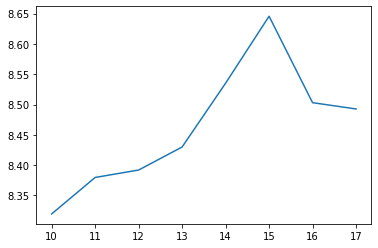

In [41]:
last = lasts[0]
inst = ytree[ytree['last'] == last]
show(inst[0])
show(inst[-1])
plt.plot(inst['timestep'], np.log10(inst['m']))

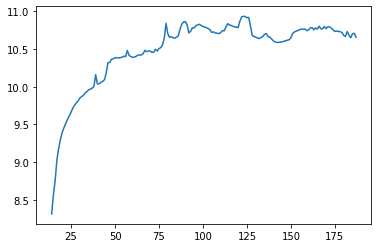

In [12]:
plt.plot(inst['timestep'], np.log10(inst['m']))

In [11]:
for ins in inst:
    print(ins['id'], ins['timestep'])

1 187
1 186
1 185
1 184
1 183
1 182
1 181
1 180
1 179
1 178
1 177
1 176
1 175
3 174
1 173
2 172
1 171
1 170
1 169
1 168
1 167
1 166
1 165
1 164
1 163
1 162
1 161
1 160
1 159
1 158
2 157
1 156
1 155
1 154
1 153
1 152
1 151
2 150
1 149
2 148
1 147
3 146
1 145
1 144
1 143
3 142
1 141
1 140
2 139
1 138
1 137
1 136
1 135
1 134
1 133
1 132
1 131
1 130
1 129
1 128
1 127
1 126
1 125
1 124
2 123
1 122
1 121
1 120
1 119
1 118
1 117
1 116
1 115
1 114
3 113
2 112
1 111
1 110
1 109
1 108
1 107
2 106
1 105
1 104
1 103
1 102
1 101
1 100
1 99
1 98
1 97
1 96
3 95
1 94
1 93
1 92
1 91
1 90
1 89
1 88
1 87
1 86
1 85
1 84
1 83
1 82
1 81
2 80
1 79
1 78
1 77
1 76
1 75
1 74
1 73
1 72
1 71
1 70
1 69
1 68
1 67
1 66
1 65
1 64
1 63
1 62
1 61
1 60
2 59
1 58
1 57
2 56
2 55
1 54
1 53
1 52
1 51
1 50
1 49
1 48
1 47
1 46
1 45
36 44
16 43
13 42
16 41
27 40
2 39
39 38
20 37
34 36
15 35
14 34
17 33
10 32
34 31
12 30
15 29
14 28
36 27
44 26
15 25
30 24
19 23
22 22
25 21
12 20
10 19
11 18
43 17
28 16
12 15
20 14
